# Analyse de Survie en Python 

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from io import StringIO
import sys

c:\Users\zergu\.conda\envs\venv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Import des données 

In [2]:
# Fichier qui donne le type de cancer activé pour chaque échnantillon
cancer = pd.read_csv('data/Breast_cancer_subtypes_samples.csv',sep=';')

In [203]:
# Expressions data 
GSE21653 = pd.read_csv('data/expression_data_GSE21653_GSE21653_log_expression_266_samples_21887_genes.csv',sep=';')
Miller = pd.read_csv('data/expression_data_Miller-2005_Miller-2005_log_expression_251_samples_14145_genes.csv',sep=';')
Naderi_Caldas = pd.read_csv('data/expression_data_Naderi-Caldas-2007_Naderi-Caldas-2007_log_expression_242_samples_14366_genes.csv',sep=';')
E_MTAB_365 = pd.read_csv('data/expression_data_probreast_microarrays_E-MTAB-365_log_expression_1190_samples_23035_genes.csv',sep=';')
GSE25066 = pd.read_csv('data/expression_data_probreast_microarrays_GSE25066_log_expression_508_samples_13815_genes.csv',sep=';')
GSE42568 = pd.read_csv('data/expression_data_probreast_microarrays_GSE42568_log_expression_121_samples_23035_genes.csv',sep=';')
TCGA_BRCA = pd.read_csv('data/expression_data_tcga_brca_TCGA-BRCA_log_fpkm_1250_samples_42851_genes.csv',sep=';')
Yau = pd.read_csv('data/expression_data_Yau-2010_Yau-2010_log_expression_683_samples_8791_genes.csv',sep=';')

In [4]:
# Annotations biocliniques
GSE21653_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.11.28_GSE21653.xlsx')
GSE25066_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.11.28_GSE25066.xlsx')
GSE42568_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.11.28_GSE42568.xlsx')
TCGA_BRCA_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.11.28_TCGA-BRCA.xlsx')
Naderi_Caldas_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.12.01_Naderi-Caldas-2007.xlsx')
Yau_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.12.01_Yau-2010.xlsx')
Miller_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.12.02_Miller-2005.xlsx')
E_MTAB_365_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.11.28_E-MTAB-365.xlsx')

c:\Users\zergu\.conda\envs\venv\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\zergu\.conda\envs\venv\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\zergu\.conda\envs\venv\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\zergu\.conda\envs\venv\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\zergu\.conda\envs\venv\lib\site-packages\openpyxl\styles\stylesheet.py:

### Création du tableau comparatif pour evaluer l'expression des différents sous types moléculaires pour un gène et un échantillon donné

In [5]:
# Création de la fonction gene_expression
# Elle renvoie un tableau qui donne (pour chaque échantillon d'une jeu de données) le type de cancer ainsi que l'expression du gène donné en entrée
def gene_expression(dataset,gene,dataset2):
    TDC = cancer[cancer["Dataset"] == dataset][["Luminal-A","Luminal-B","HER2-enriched","Basal-like"]]
    ech = cancer[cancer["Dataset"] == dataset]['Sample']
    type_cancer = TDC.apply(lambda row: ''.join(row.keys()[row == 1]), axis=1)
    type_cancer = pd.DataFrame(type_cancer)
    type_cancer = type_cancer.T
    type_cancer.columns = ech.to_list()
    
    dataset2.gene_symbol = dataset2.gene_symbol.convert_dtypes()
    EG = dataset2[dataset2.gene_symbol == gene][cancer[cancer["Dataset"] == dataset]['Sample']]
    df = pd.concat([type_cancer,EG],axis=0)
    df.index = ['type', 'value']
    df = df.T
    df.value = pd.to_numeric(df.value)
    df['type'] = df['type'].replace({'': 'Non-tumour'})
    return df # sns.boxplot(x=df["type"],y=df["value"],orient = "v")
gene_expression('Naderi-Caldas-2007',"BOP1",globals()['Naderi_Caldas']) # -> renvoie aucun type
gene_expression('TCGA-BRCA',"EZH2",globals()['TCGA_BRCA']) # Lui il marche

,type,value
TCGA-A7-A0CE-11A,Non-tumour,1.371113
TCGA-A7-A0CH-11A,Non-tumour,0.940731
TCGA-A7-A0D9-11A,Non-tumour,0.592445
TCGA-A7-A0DB-11A,Non-tumour,1.155361
TCGA-A7-A0DC-11A,Non-tumour,1.053667
...,...,...
TCGA-WT-AB44-01A,Luminal-A,2.235114
TCGA-XX-A899-01A,Luminal-A,2.626276
TCGA-XX-A89A-01A,Luminal-A,2.641962
TCGA-Z7-A8R5-01A,Luminal-A,1.724607


Pour chaque échantillon (dans un jeu de données), nous comparons chaque type de cancer contre tous les autres. Nous considérons au total 6 types de cancers : 

- Non-tumour
- Tumour
- Luminal-A
- Luminal-B
- HERB2
- Basal-Like

### Enrichissement du tableau avec le Fold Change

In [6]:
# Le code ci-dessous permet de créer un tableau (en s'appuyant sur la fonction précédente : gene_expression)
# Le fold change permet de quantifier l'écart un sous type moléculaires avec le reste
def get_logfc(dataset,gene,dataset2):
    df = gene_expression(dataset,gene,dataset2)
    df2 = df.groupby("type")["value"].mean()
    result = pd.DataFrame({'gene': [gene] * len(df2.index), 'dataset': [dataset] * len(df2.index), 'type': df2.index, 'LOGfc': [None] * len(df2.index),
                           'fc': [None] * len(df2.index), 'F': [None]*len(df2.index), 'pvalue': [None] * len(df2.index),
                           'FDR': [None] * len(df2.index)})
    for group in result.index:
        other_groups = result.index.difference([group])
        average_value = df2[other_groups].mean()
        fc = df2[group].mean() - average_value
        F, p_value = f_oneway(df['value'][df.type == result['type'][group]], df['value'][df.type != result['type'][group]])
        p_valeurs_corrigees = multipletests(p_value, method='fdr_bh')[1][0]
        result.at[group, 'LOGfc'] = fc
        result.at[group, 'fc'] = 2**fc
        result.at[group, 'F'] = F
        result.at[group, 'pvalue'] = p_value
        result.at[group, 'FDR'] = p_valeurs_corrigees
    return result

# Ici nous avons un exemple pour le gène EZH2 dans le jeu de données TCGA-BRCA
get_logfc('TCGA-BRCA',"EZH2",TCGA_BRCA)
# Ici nous avons un exemple pour le gène BOP1 dans le jeu de données TCGA-BRCA
get_logfc('TCGA-BRCA',"BOP1",TCGA_BRCA)

,gene,dataset,type,LOGfc,fc,F,pvalue,FDR
0,BOP1,TCGA-BRCA,Basal-like,1.184223,2.27241,330.693096,0.0,0.0
1,BOP1,TCGA-BRCA,HER2-enriched,-0.014224,0.990189,0.799812,0.371326,0.371326
2,BOP1,TCGA-BRCA,Luminal-A,-0.429357,0.742593,61.594212,0.0,0.0
3,BOP1,TCGA-BRCA,Luminal-B,0.082092,1.058552,7.381185,0.006684,0.006684
4,BOP1,TCGA-BRCA,Non-tumour,-0.822734,0.56537,82.705159,0.0,0.0


Nous avons cette fois-ci, un tableau qui donne pour chaque ligne l'expression d'un gène pour un sous type de cancer donné dans un jeu de donnée. La première ligne par exemple nous donne l'expression du gène BOP1, dans le jeu de données TCGA-BRCA, lorsque le type Basal-Like est activé. Plus précisement, le fold change (FC dans le tableau), nous donne le niveau de significativité de la différence entre le groupe Basal-Like et tous les autres. 

### Généralisation du tableau pour tous les gènes d'un jeu de données 

Jusqu'ici, nous avions donné 

In [7]:
# Exemple avec TCGA-BRCA
df = get_logfc('TCGA-BRCA',TCGA_BRCA.gene_symbol[0],TCGA_BRCA)
for g in TCGA_BRCA.gene_symbol[1:100]: # len(TCGA_BRCA.gene_symbol)
    df = pd.concat([df,get_logfc('TCGA-BRCA',g,TCGA_BRCA)],axis=0)

# Il faut reset les indices
df = df.reset_index(drop=True)

In [8]:
# Le dataframe est stocké 
df.to_pickle('data/TCGA_volcano.pkl')

# Il suffit de mettre la commande suivante pour le recharger : 
df = pd.read_pickle('data/TCGA_volcano.pkl')
df

,gene,dataset,type,LOGfc,fc,F,pvalue,FDR
0,A1BG,TCGA-BRCA,Basal-like,-0.022586,0.984466,35.299432,0.0,0.0
1,A1BG,TCGA-BRCA,HER2-enriched,-0.025979,0.982154,16.428854,0.000054,0.000054
2,A1BG,TCGA-BRCA,Luminal-A,0.030754,1.021546,50.570851,0.0,0.0
3,A1BG,TCGA-BRCA,Luminal-B,0.011032,1.007676,0.004666,0.945552,0.945552
4,A1BG,TCGA-BRCA,Non-tumour,0.006779,1.00471,0.686409,0.407551,0.407551
...,...,...,...,...,...,...,...,...
495,ADH4,TCGA-BRCA,Basal-like,-0.033752,0.976876,1.215331,0.270496,0.270496
496,ADH4,TCGA-BRCA,HER2-enriched,-0.136031,0.910019,10.900043,0.000989,0.000989
497,ADH4,TCGA-BRCA,Luminal-A,-0.072414,0.951046,32.084071,0.0,0.0
498,ADH4,TCGA-BRCA,Luminal-B,-0.13577,0.910184,30.365553,0.0,0.0


### Construction du volcano plot

Pour construire le Volcano Plot, nous prenons le Log2 du Fold Change en abscisse et le -log10 de la pvalue en ordonnée. Le seuil de significativité sera determiné à partir de la valeur par défaut de 0.05. Dans le graphique, le seuil de significativité est défini par une ligne horizontale en pointillé 

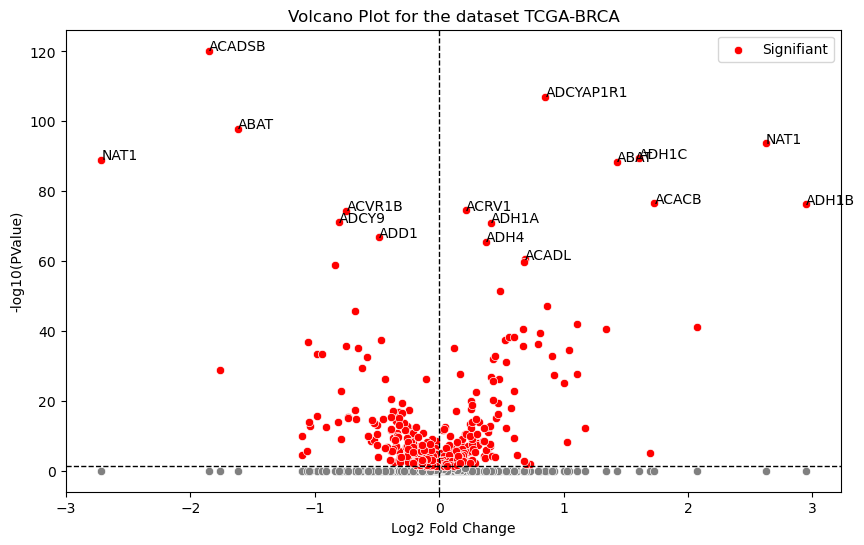

In [17]:
# Je commence par définir un seuil de significativité pour la PValue
seuil = -np.log10(0.05)
pvlog10 = -np.log10(df.pvalue.astype(float))
pvlog10 = pvlog10.reset_index(drop=True)
# df["gene"][pvlog10[pvlog10 > 150].index]

# Ensuite je crée le volcano plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='LOGfc', y='pvalue', data=df, color='grey')
sns.scatterplot(x=df[-np.log10(df.pvalue.astype(float)) > seuil]['LOGfc'].values,
                y=pvlog10[pvlog10 > seuil].values,
                color='red', label='Signifiant')

# plt.ylim(-50,100)

plt.title('Volcano Plot for the dataset TCGA-BRCA') # plt.title('Volcano Plot pour le jeu de données TCGA-BRCA')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(PValue)')

# Pour ajouter une ligne verticale pour mettre en évidence le seuil de significativité
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.axhline(y=seuil, color='black', linestyle='--', linewidth=1)

# Pour donner le label des -log10(pv) superieurs à 60 
for i,gene in zip(df["gene"][pvlog10[pvlog10 > 60].index].index,df["gene"][pvlog10[pvlog10 > 60].index].values):
    plt.annotate(gene, (df.iloc[i]['LOGfc'], -np.log10(df.iloc[i]['pvalue'].astype(float))))

plt.legend()
plt.show()

Toutes les valeurs au dessus de la ligne en pointillé ont un Fold Change qui peut être considéré comme significatif. Au vu du grand nombre de points, il est impossible de préciser le libéllé de chaque point. Cependant, nous affichons les libéllé des points pour lesquels le Fold Change est le plus significatif.

### Réaliser une analyse de survie sur python 

On commence avec un premier exemple dans le jeu de données EMTAB pour le gène EZH2

In [232]:
expression = E_MTAB_365[E_MTAB_365.gene_symbol == "EZH2"]
expression.dropna(axis=1)

,id_gene,gene_symbol,CIT_DSOA_001,CIT_DSOA_002,CIT_DSOA_003,CIT_DSOA_004,CIT_DSOA_005,CIT_DSOA_006,CIT_DSOA_007,CIT_DSOA_008,...,CIT_DSOA_528,CIT_DSOA_529,CIT_DSOA_530,CIT_DSOA_531,CIT_DSOA_532,CIT_DSOA_533,CIT_DSOA_534,CIT_DSOA_535,CIT_DSOA_536,CIT_DSOA_537
1513,2146,EZH2,8.426623,6.877132,7.572731,5.29231,6.226845,6.886607,7.484511,6.418675,...,6.682147,6.449759,5.907661,6.008499,6.067995,6.238021,6.1007,6.347094,5.382535,5.934367


In [233]:
# Recuperons maintenant les données de survie 
survie = E_MTAB_365_EG[["id_sample","os_months","os_censor","dfs_months","dfs_censor"]]
survie = survie.dropna()

In [206]:
# Nous conservons uniquement les échantillons pour lesquelles nous avons une expression de gènes (pas de NA)
expression = expression[E_MTAB_365_EG[["id_sample","os_months","os_censor","dfs_months","dfs_censor"]]['id_sample'].values].dropna(axis=1)

In [207]:
# On passe la ligne de données en une colonne et on la renomme "value"
expression = expression[survie.id_sample].T
expression.columns = ["value"]

In [208]:
survie = pd.concat([survie.reset_index(drop=True),expression.reset_index(drop=True)],axis=1)

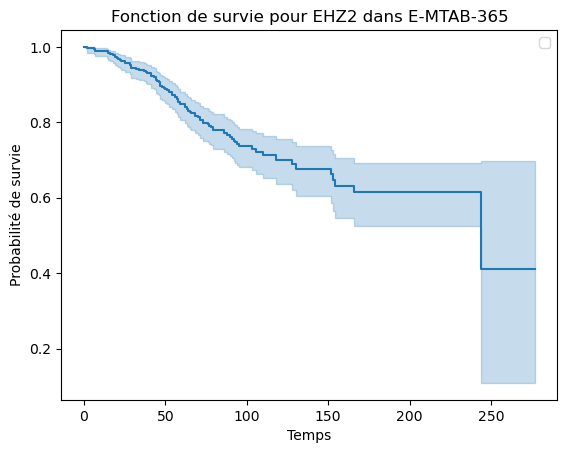

In [209]:
# Initialiser le modèle Kaplan-Meier
kmf = KaplanMeierFitter()

# Ajuster le modèle aux données de survie
kmf.fit(durations=survie['os_months'], event_observed=survie['os_censor'])

# Afficher la fonction de survie
kmf.plot_survival_function()
plt.title('Fonction de survie pour EHZ2 dans E-MTAB-365')
plt.xlabel('Temps')
plt.ylabel('Probabilité de survie')
plt.legend("")
plt.show()

Ci-dessus, nous avons un premier exemple d'analyse de survie pour le gène EHZ2 dans le jeu de données E-MTAB-365

### Courbe Low et High dans la courbe de survie 

In [210]:
mediane = np.percentile(survie["value"],50)
survie[survie["value"] > mediane]["os_months"]

0       78.0
1       62.0
2      110.0
5      104.0
6       75.0
       ...  
406     28.0
411     97.0
413    166.0
417    186.0
418    104.0
Name: os_months, Length: 214, dtype: float64

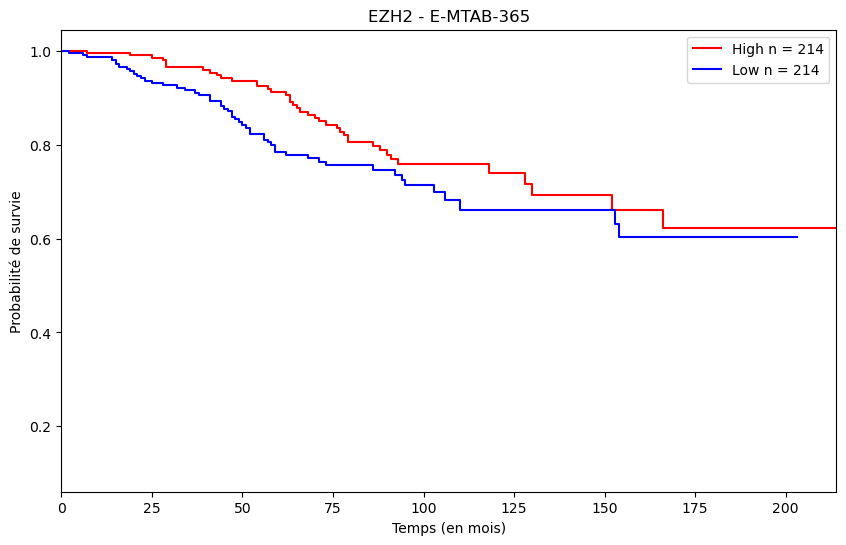

In [211]:
# Définir le critère pour séparer les 2 groupes : 
mediane = np.percentile(survie["value"],50)

# Créer deux instances distinctes de KaplanMeierFitter
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

# Definition des 2 groupes (Low et High)
high = survie[survie["value"] > mediane]
low = survie[survie["value"] < mediane]

# Ajuster les modèles aux données de survie respectives
kmf1.fit(durations=high["os_months"], event_observed=high['os_censor'])
kmf2.fit(durations=low["os_months"], event_observed=low['os_censor'])

# Tracer les courbes de survie
plt.figure(figsize=(10, 6))
kmf2.plot_survival_function(label=f'High n = {high.shape[0]}',color='red',ci_alpha=0)
kmf1.plot_survival_function(label=f'Low n = {low.shape[0]}',color='blue',ci_alpha=0)


plt.xlim(0,min(len(low),len(high)))

# Ajouter des titres et légendes
plt.title(f'EZH2 - E-MTAB-365') 
# plt.title(f'EZH2 - E-MTAB-365\ncox p-value : {res['p'].values}\nlogrank p-value : {res_logr.summary['p']}')
plt.xlabel('Temps (en mois)') # plt.xlabel('Temps')
plt.ylabel('Probabilité de survie') # plt.ylabel('Probabilité de survie')
plt.legend()

# Afficher le graphique
plt.show()


#### Généraliser avec une fonction qui prend en entrée un gène et un jeu de données

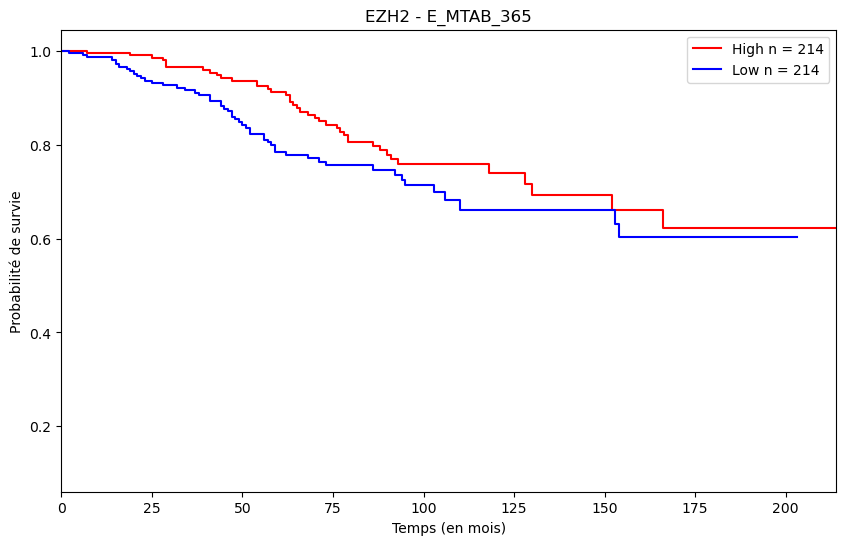

In [236]:
def get_survie(dataset,dataset2, gene):
    data = globals()[dataset]
    data2 = globals()[dataset2]
    expression = data[data.gene_symbol == gene]
    expression.dropna(axis=1)
    survie = data2[["id_sample","os_months","os_censor","dfs_months","dfs_censor"]]
    # Ce if permet d'arrêter la fonction si les données sont manquantes
    if(survie.os_months.value_counts().shape[0] == 0 or survie.os_censor.value_counts().shape[0] == 0):
        return "Les données de survie ne sont pas disponible"
    survie = survie.dropna()
    expression = expression[data2[["id_sample","os_months","os_censor","dfs_months","dfs_censor"]]['id_sample'].values].dropna(axis=1)
    expression = expression[survie.id_sample].T
    expression.columns = ["value"]
    survie = pd.concat([survie.reset_index(drop=True),expression.reset_index(drop=True)],axis=1)
    mediane = np.percentile(survie["value"],50)
    survie[survie["value"] > mediane]["os_months"]

    mediane = np.percentile(survie["value"],50)
    kmf1 = KaplanMeierFitter()
    kmf2 = KaplanMeierFitter()
    high = survie[survie["value"] > mediane]
    low = survie[survie["value"] < mediane]
    kmf1.fit(durations=high["os_months"], event_observed=high['os_censor'])
    kmf2.fit(durations=low["os_months"], event_observed=low['os_censor'])
    plt.figure(figsize=(10, 6))
    kmf2.plot_survival_function(label=f'High n = {high.shape[0]}',color='red',ci_alpha=0)
    kmf1.plot_survival_function(label=f'Low n = {low.shape[0]}',color='blue',ci_alpha=0)
    plt.xlim(0,min(len(low),len(high)))
    plt.title(f'{gene} - {dataset}') 
    # plt.title(f'EZH2 - E-MTAB-365\ncox p-value : {res['p'].values}\nlogrank p-value : {res_logr.summary['p']}')
    plt.xlabel('Temps (en mois)')
    plt.ylabel('Probabilité de survie')
    plt.legend()
    plt.show()

# Voici un exemple
# On commence par renseigner la chaîne de caractère associée au dataframe qui donne les données d'expressions 
# puis celle du dataframe qui donne les annotations biocliniques
get_survie("E_MTAB_365","E_MTAB_365_EG","EZH2")

## Travail sur les 605 gènes d'intêrets

Dans la base précédente, nous avions plus de 20 000 gènes qu'il aurait fallu analyser. Nous allons réduire notre base à 605 gènes d'intêret, ils sont les plus susceptible d'être impliquer dans le développement de cancer du sein chez l'être humain. 

### Import des listes des gènes d'intêrets

Les 605 gènes d'intêrets sont contenu dans des fichiers textes. Parmi les 605 gènes d'intêrets, nous en distinguons 3 types : 

- La famille des KDM (35)
- La famille des KMT (109)
- La famille des KMB (461)

In [213]:
# Import des 35 KDM
with open("genes_interets/KDM.txt", 'r') as f:
    lignes = f.readlines()
id = eval(lignes[0].strip())
nom_gene = eval(lignes[1].strip())
KMT = pd.DataFrame({'id': id, 'nom_gene': nom_gene}) # , 'type': np.repeat("KMT",len(id))


# Import des 109 KMT
with open("genes_interets/KMT.txt", 'r') as f:
    lignes = f.readlines()
id = eval(lignes[0].strip())
nom_gene = eval(lignes[1].strip())
KDM = pd.DataFrame({'id': id, 'nom_gene': nom_gene}) # , 'type': np.repeat("KDM",len(id))

# Import des 461 KMB
with open("genes_interets/KMB.txt", 'r') as f:
    lignes = f.readlines()
id = eval(lignes[0].strip())
nom_gene = eval(lignes[1].strip())
KMB = pd.DataFrame({'id': id, 'nom_gene': nom_gene}) # , 'type': np.repeat("KMB",len(id))

Regroupons maintenant les 3 fichiers en un seul

In [214]:
GI = pd.concat([KMT,KDM,KMB])
GI.head()

,id,nom_gene
0,65990,ANTKMT
1,55870,ASH1L
2,134145,ATPSCKMT
3,144233,BCDIN3D
4,154743,BMT2


In [215]:
GI.shape

(679, 2)

In [216]:
GSE21653 = GSE21653[GSE21653["id_gene"].isin(GI.id.values)]
Miller = Miller[Miller["id_gene"].isin(GI.id.values)]
Naderi_Caldas = Naderi_Caldas[Naderi_Caldas["id_gene"].isin(GI.id.values)]
E_MTAB_365 = E_MTAB_365[E_MTAB_365["id_gene"].isin(GI.id.values)]
GSE25066 = GSE25066[GSE25066["id_gene"].isin(GI.id.values)]
GSE42568 = GSE42568[GSE42568["id_gene"].isin(GI.id.values)]
TCGA_BRCA = TCGA_BRCA[TCGA_BRCA["id_gene"].isin(GI.id.values)]
Yau = Yau[Yau["id_gene"].isin(GI.id.values)]

Une fois que l'on a réduit les jeux de données à quelques centaines de gènes d'intérêts, nous intégrons le type de gènes parmi les 3 familles présentées plus tôt (KDM, KMB, KMT) dans les jeux de données (c'est une information supplémentaires qui pourra eventuellement nous servir par la suite)

In [217]:
GI.columns = ["id_gene", "nom_gene"] # , "type"

In [187]:
# Ces commandes permettent de rajouter le type de gène dans les différents jeux de données
# GSE21653 = GSE21653.merge(GI,how='left',on = 'id_gene')
# Miller = Miller.merge(GI,how='left',on = 'id_gene')
# Naderi_Caldas = Naderi_Caldas.merge(GI,how='left',on = 'id_gene')
# E_MTAB_365 = E_MTAB_365.merge(GI,how='left',on = 'id_gene')
# GSE25066 = GSE25066.merge(GI,how='left',on = 'id_gene')
# GSE42568 = GSE42568.merge(GI,how='left',on = 'id_gene')
# TCGA_BRCA = TCGA_BRCA.merge(GI,how='left',on = 'id_gene')
# Yau = Yau.merge(GI,how='left',on = 'id_gene')

## Nous pouvons dès à présent travailler sur une base réduite de gènes 

In [237]:
get_survie("GSE21653","GSE21653_EG","EZH2")

'Les données de survie ne sont pas disponible'